In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import joblib

In [2]:
def fix_okved(o: str) -> str:
    if o is None:
        return

    while o[-1] == '0' and '.' in o:
        if o[-2] == '.':
            o = o[:-2]
        else:
            o = o[:-1]
    return o

In [3]:
version_name = '0_4384'

In [4]:
okved_data = pd.read_csv('../data/okved2/okved_2014_w_sections.csv', index_col=0)
sections = okved_data['section_id'].values

idx_to_okved = {0: 'root'}
idx_to_okved |= okved_data['native_code'].to_dict()
okved_to_idx = {v: k for k, v in idx_to_okved.items()}

embeddings_bert = np.load('../data/okved2/okved_embeddings.npy')
gos_contracts_embeddings = np.load("../data/okved2/okved_contact_emb.npy")
okved_to_number_mapping = joblib.load('../data/okved2/okved_to_number_mapping.pickle')
embds_true = np.zeros_like(embeddings_bert)
# creating mapping for gos description
for k, v in idx_to_okved.items():
    if v in okved_to_number_mapping:
        idx = okved_to_number_mapping[v]
        embds_true[k,:] = gos_contracts_embeddings[idx]
gos_contracts_embeddings = embds_true
embeddings_bert = np.hstack((embeddings_bert, gos_contracts_embeddings))

embeddings_model = np.load(f'../results/embs/Cheb.npy')
okved_consumption = pd.read_csv('../data/stats/okved_consumption.csv')

In [12]:
from pathlib import Path
STATS_ROOT = Path('C:/Users/egrli/FU_Projects/Курсач/intelligent_okved_embeddings/data/stats')


In [13]:
prod_stats = (pd.read_excel(STATS_ROOT / 'затраты_выпуск.xlsx',
                            skiprows=1,
                            sheet_name='Затраты_Выпуск_Плоская',
                            dtype=str)
                .iloc[:, 1:]
                .set_index('Коды')
                )
prod_stats.columns = [str(c).strip() for c in prod_stats.columns]
# the matrix should have same cols and rows names
assert np.all(prod_stats.columns == prod_stats.index)

# for 2016 year OKVED and OKPD v1 are used
okved_versions = pd.read_excel(STATS_ROOT / 'ОКВЭД2-ОКВЭД2007.xls', skiprows=1,
                            usecols=[0, 2],
                            names=['OKVED2', 'OKVED1'],
                            sheet_name='Лист1')
old_to_new = okved_versions.dropna().set_index('OKVED1')['OKVED2'].to_dict()
# first 4 symbols of the OKDP code match with the appropriate OKVED code
# source file was preprocessed manually
new_index_columns = prod_stats.columns.map(old_to_new)
prod_stats.columns = new_index_columns
prod_stats.index = new_index_columns
prod_stats = prod_stats.loc[prod_stats.index.notna(), prod_stats.columns.notna()]
# cast to float and normalize by row
prod_stats_np = prod_stats.values.astype(float)
prod_stats_np /= prod_stats_np.sum(axis=1).reshape(-1, 1)
n = len(prod_stats)
# for now, we use only the upper triangle of the matrix
# so mask the lower triangle with -1
prod_stats_np[np.tril_indices(n, k=-1)] = -1
prod_stats_upper = (pd.DataFrame(prod_stats_np,
                                columns=prod_stats.columns,
                                index=prod_stats.index)
                        .dropna())
okved_consumption = (prod_stats_upper.unstack()
                                    .reset_index()
                                    .rename(columns={"level_0": "okved_provider",
                                                        "level_1": "okved_consumer",
                                                        0: "normalized_consumption"}))

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 2.0.1 for xls Excel support Use pip or conda to install xlrd.

In [14]:
prod_stats

,01.1,01.2,01.4,01.5,02,05,10,11.10,11.2,12,...,73,74,75,80,85,90,91,92,93,95
Коды,,,,,,,,,,,,,,,,,,,,,
01.1,193987.5,193987.5,4065,168.5,591,224,0.5,14.5,2,0,...,385,2039,10791.5,2042,11708.5,98,431,528,256.5,0
01.2,193987.5,193987.5,4065,168.5,591,224,0.5,14.5,2,0,...,385,2039,10791.5,2042,11708.5,98,431,528,256.5,0
01.4,23667,23667,1444,1,8,23,0,0,1,0,...,80,586,15807,65,177,83,14,402,48,0
01.5,14,14,0,2532,4,0,0,0,0,0,...,0,4,737,0,2,1,41,7,0,0
02,472.5,472.5,29,4,32409,16,1,0,9,0,...,9,804,6758,134,274,66,16,214,74,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,685.5,685.5,347,3,71,72,600,4133,1996,4,...,3089,4952,90486,8032,18313,15349,328,7107,580,0
91,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92,15.5,15.5,5,26,2,4,36,92,169,0,...,458,199703,34516,4694,3659,215,18618,157064,407,0


In [7]:
okved_consumption = pd.read_excel('../data/stats/затраты_выпуск.xlsx')


In [8]:
okved_consumption

,Продукты ОКПД,Unnamed: 1,Продукция сельского хозяйства,Продукция сельского хозяйства.1,"Услуги в области растениеводства и животноводства, кроме ветеринарных услуг, услуги в области декоративного садоводства","Услуги, связанные с охотой, ловлей и разведением диких животных","Продукция лесоводства, лесозаготовок и связанные с этим услуги","Рыба и прочая продукция рыболовства и рыбоводства; услуги, связанные с рыболовством и рыбоводством",Уголь каменный и уголь бурый (лигнит); торф,"Нефть, включая нефть, получаемую из битуминозных минералов; сланцы горючие (битуминозные) и песчаники битуминозные",...,"Услуги, связанные с научными исследованиями и экспериментальными разработками","Прочие услуги, связанные с предпринимательской деятельностью","Услуги в сфере государственного управления, обеспечения военной безопасности и социального обеспечения",Услуги в области образования,Услуги в области здравоохранения и социальные услуги,"Услуги по удалению сточных вод и отходов, улучшению санитарного состояния и аналогичные услуги","Услуги общественных организаций, не включенные в другие группировки","Услуги по организации отдыха, развлечений, культуры и спорта",Услуги персональные прочие,Услуги домашних хозяйств с наемными работниками
0,NaN,Коды,1.1,1.2,1.4,1.5,2.0,5.0,10.0,11.1,...,73.0,74.0,75.0,80.0,85.0,90.0,91.0,92.0,93.0,95
1,Продукция сельского хозяйства,01.1,193987.5,193987.5,4065.0,168.5,591.0,224.0,0.5,14.5,...,385.0,2039.0,10791.5,2042.0,11708.5,98.0,431.0,528.0,256.5,0
2,Продукция сельского хозяйства,01.2,193987.5,193987.5,4065.0,168.5,591.0,224.0,0.5,14.5,...,385.0,2039.0,10791.5,2042.0,11708.5,98.0,431.0,528.0,256.5,0
3,Услуги в области растениеводства и животноводс...,01.4,23667.0,23667.0,1444.0,1.0,8.0,23.0,0.0,0.0,...,80.0,586.0,15807.0,65.0,177.0,83.0,14.0,402.0,48.0,0
4,"Услуги, связанные с охотой, ловлей и разведени...",01.5,14.0,14.0,0.0,2532.0,4.0,0.0,0.0,0.0,...,0.0,4.0,737.0,0.0,2.0,1.0,41.0,7.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,"Услуги по удалению сточных вод и отходов, улуч...",90,685.5,685.5,347.0,3.0,71.0,72.0,600.0,4133.0,...,3089.0,4952.0,90486.0,8032.0,18313.0,15349.0,328.0,7107.0,580.0,0
119,"Услуги общественных организаций, не включенные...",91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
120,"Услуги по организации отдыха, развлечений, кул...",92,15.5,15.5,5.0,26.0,2.0,4.0,36.0,92.0,...,458.0,199703.0,34516.0,4694.0,3659.0,215.0,18618.0,157064.0,407.0,0
121,Услуги персональные прочие,93,2.0,2.0,1.0,2.0,0.0,0.0,35.0,43.0,...,87.0,758.0,3136.0,1402.0,9290.0,92.0,919.0,3305.0,491.0,0


In [6]:
prov_indices = okved_consumption['okved_provider'].map(fix_okved).map(okved_to_idx)
cons_indices = okved_consumption['okved_consumer'].map(fix_okved).map(okved_to_idx)

X_bert = np.column_stack((embeddings_bert[prov_indices], embeddings_bert[cons_indices]))
X_bert = StandardScaler().fit_transform(X_bert)
X_model = np.column_stack((embeddings_model[prov_indices], embeddings_model[cons_indices]))
X_model = StandardScaler().fit_transform(X_model)
y = okved_consumption['normalized_consumption']

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

model = LinearRegression().fit(X_model, y )
score = model.score(X_model, y) 
print('Модель: ', score)

model = LinearRegression().fit(X_bert, y)
score = model.score(X_bert, y) 
print('Берт: ', score)

Модель:  0.10561800152645395
Берт:  0.10354746104157875


AS-IS:

Модель:  0.11581006643342462\
Берт:  0.09472846437770266\
TO-BE:

Модель:  0.11581006643342462\
Берт:  0.10354746104157875


In [7]:
bert_scores = []
for i in tqdm(range(100), leave=False):
    model = MLPRegressor().fit(X_bert, y)
    score = model.score(X_bert, y) 
    bert_scores.append(score)

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
model_scores = []
for i in tqdm(range(100), leave=False):
    model = MLPRegressor().fit(X_model, y)
    score = model.score(X_model, y) 
    model_scores.append(score)

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
with open(f'scores_{version_name}.pickle', 'wb') as fp:
    pickle.dump({"model_scores":model_scores, "bert_scores": bert_scores}, fp)

In [9]:
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')

Модель: 0.25±0.34
Берт: -0.26±0.79


In [10]:
np.std(model_scores), np.std(bert_scores)

(0.34468616217094716, 0.7891457486689374)

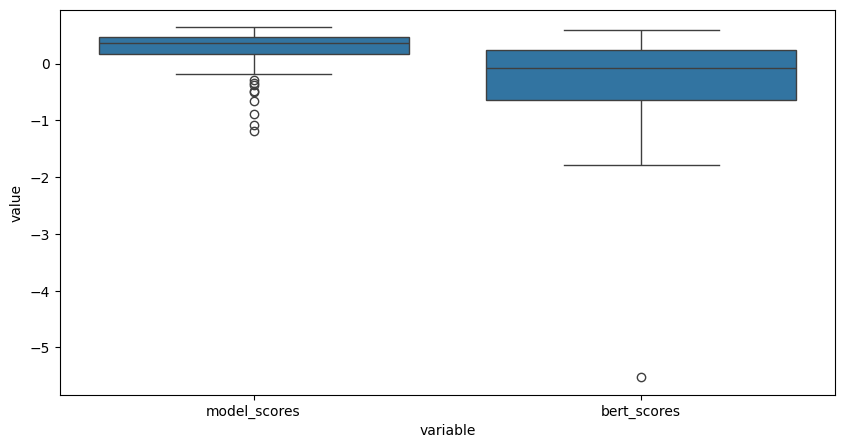

In [11]:
import seaborn as sns

df = pd.DataFrame({'model_scores': model_scores, 'bert_scores': bert_scores})
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(x='variable', y='value', data=df.melt(), ax=ax)

In [16]:
okved_consumption_cut = okved_consumption.query('okved_provider != okved_consumer')
okved_consumption_cut.loc[:, 'okved_provider'] = okved_consumption_cut['okved_provider'].map(fix_okved)
okved_consumption_cut.loc[:, 'okved_consumer'] = okved_consumption_cut['okved_consumer'].map(fix_okved)

prov_indices = okved_consumption_cut['okved_provider'].map(okved_to_idx)
cons_indices = okved_consumption_cut['okved_consumer'].map(okved_to_idx)
y = okved_consumption_cut['normalized_consumption']

In [17]:
from sklearn.metrics import pairwise_distances

In [18]:
def max_provider(group):
    return group.loc[group['normalized_consumption'].idxmax(), 'okved_provider']

def mrr(okved_consumption, embeddings):
    largest_provider = okved_consumption.groupby('okved_consumer').apply(max_provider)
    largest_provider_idx = largest_provider.map(okved_to_idx)
    
    all_providers = okved_consumption['okved_provider'].unique()
    all_providers_idx = np.array([okved_to_idx[o] for o in all_providers])
    all_providers_emb = embeddings[all_providers_idx]
    pwd = pairwise_distances(all_providers_emb)

    rs = []
    for idx, provider_code in enumerate(all_providers):
        if provider_code not in largest_provider_idx.index:
            print(f'Skipping {provider_code}...')
            continue
        sorted_idx = all_providers_idx[np.argsort(pwd[idx])]
        rank, = np.where(sorted_idx==largest_provider_idx[provider_code])
        rs.append(rank[0])
    rs = np.array(rs)
    return np.mean(1 / (rs + 1))


Skipping 94...
Skipping 97...
Skipping 94...
Skipping 97...


C:\Users\egrli\AppData\Local\Temp\ipykernel_25484\2396725343.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  largest_provider = okved_consumption.groupby('okved_consumer').apply(max_provider)
C:\Users\egrli\AppData\Local\Temp\ipykernel_25484\2396725343.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  largest_provider = okved_consumption.groupby('okved_consumer').apply(max_provider)


Text(0, 0.5, 'MRR $\\leftarrow$')

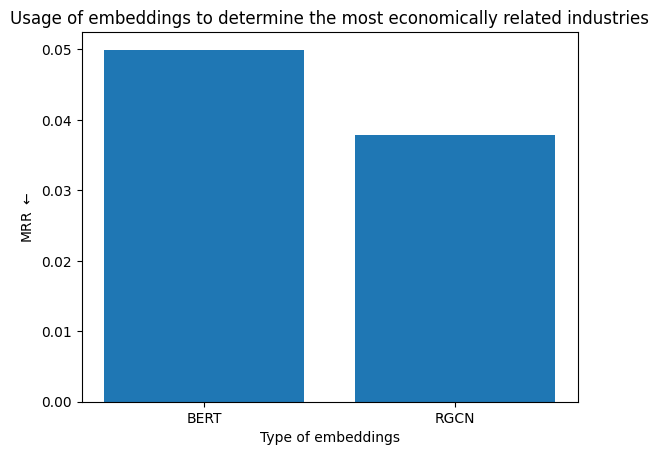

In [19]:
mrr_rgcn = mrr(okved_consumption_cut, embeddings_model)
mrr_bert = mrr(okved_consumption_cut, embeddings_bert)
plt.bar(['BERT', 'RGCN'], [mrr_bert, mrr_rgcn])
plt.title('Usage of embeddings to determine the most economically related industries')
plt.xlabel('Type of embeddings')
plt.ylabel('MRR $\leftarrow$')

In [20]:
from numpy.linalg import norm

In [21]:
okved_consumption_cut

,okved_provider,okved_consumer,normalized_consumption
1,01.4,01.1,0.111727
3,01.6,01.1,0.002341
4,01.6,01.4,0.002341
6,01.7,01.1,0.000097
7,01.7,01.4,0.000097
...,...,...,...
7371,97,85,0.000000
7372,97,86,0.000000
7373,97,37,0.000000
7374,97,93,0.000000


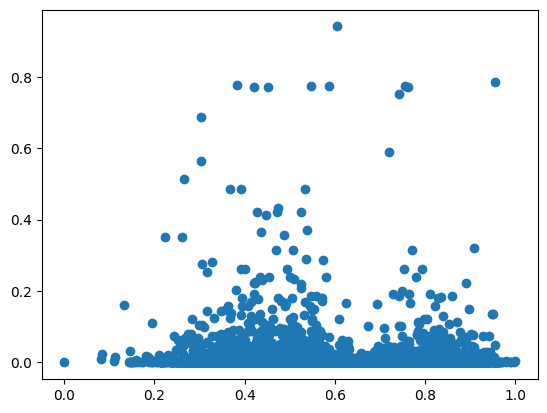

In [22]:
prov_indices = okved_consumption_cut['okved_provider'].map(okved_to_idx)
cons_indices = okved_consumption_cut['okved_consumer'].map(okved_to_idx)

provider_emb = embeddings_bert[prov_indices] 
consumer_emb = embeddings_bert[cons_indices]

emb_closeness = norm(provider_emb - consumer_emb, ord=2, axis=1)
emb_closeness = (emb_closeness - emb_closeness.min()) / np.ptp(emb_closeness)
ec_closeness = okved_consumption_cut['normalized_consumption']
plt.scatter(emb_closeness, ec_closeness)
# plt.ylim(0.0, 0.2)